#Imports and Setup


In [190]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import sklearn as skl
import chardet

#Setup
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Import the Data

In [191]:
cities = ['Boston', 'Canberra', 'Geneva', 'Ottawa']

In [192]:
# Detect the encoding of the data so we import it correctly using panda
path1 = 'enter your path here'
path2 = 'enter your path here'

with open(path1, 'rb') as f:
    raw_data = f.read()

result = chardet.detect(raw_data)
print(result['encoding'])

MacRoman


In [193]:
def import_dataset(dataset_path=None):
  """
  Function to import datasets and throw errors given wrong dataset paths.

  Parameters:
  - dataset_path (str): initialized to None, such that if no path is given an error can be thrown by function.

  Returns:
  - pd.read_csv(dataset_path) (DataFrame): DataFrame of dataset
  """
  if dataset_path is None: #if no argument given
    print("Error: No dataset path specified.")
    return None
  try:
    return pd.read_csv(dataset_path, encoding="macroman").values #new encoding given error?
  except FileNotFoundError: #if incorrect path
    print(f"Error: {dataset_path} not found.")
    return None
  except UnicodeDecodeError:
    print(f"Error: Unicode decoding issue with {dataset_path}. Try a different encoding.")
    return None


In [194]:
test_data_og = import_dataset(path1)
train_data_og = import_dataset(path2)

# Slice the first row to remove data label
test_data = test_data_og.copy()
train_data = train_data_og.copy()

# Seperate class from data
test_x = test_data[:, 1]
test_id = test_data[:, 0]

train_x = train_data[:, 0]
train_y = train_data[:, 1]

print(train_data.shape)
print(test_data.shape)

(1400, 2)
(600, 2)


In [195]:
# Cross validate

In [196]:
print(train_x[1060], train_y[1060])

[Route de Feney](https://www.google.com/maps/@46.2273354,6.129715,3a,75y,127.45h,71.97t/data=!3m7!1e1!3m5!1sX49B7UYEJXrYdgfOob8IUQ!2e0!6shttps:%2F%2Fstreetviewpixels-pa.googleapis.com%2Fv1%2Fthumbnail%3Fcb_client%3Dmaps_sv.tactile%26w%3D900%26h%3D600%26pitch%3D18.03169011430232%26panoid%3DX49B7UYEJXrYdgfOob8IUQ%26yaw%3D127.44636653503!7i16384!8i8192?entry=ttu&g_ep=EgoyMDI0MTIxMS4wIKXMDSoASAFQAw%3D%3D). Fortunately in Geneva's it is not that brutal. Geneva


Looking at the bar char below we can see that we are using a balanced dataset with an equal number of samples for each class, which helps mitigate class imbalance issues. To preprocess the text, we will apply TF-IDF vectorization with min_df=2 and max_df=0.9. This combination allows to filter out very rare terms that appear in fewer than two documents, which are unlikely to generalize well, while also removing extremely common terms that appear in over 90% of documents, as these are often stopwords or generic terms with little discriminative value. Additionally, we will consider using both unigrams and bigrams (ngram_range=(1,2)) to capture important single words as well as informative two-word phrases.

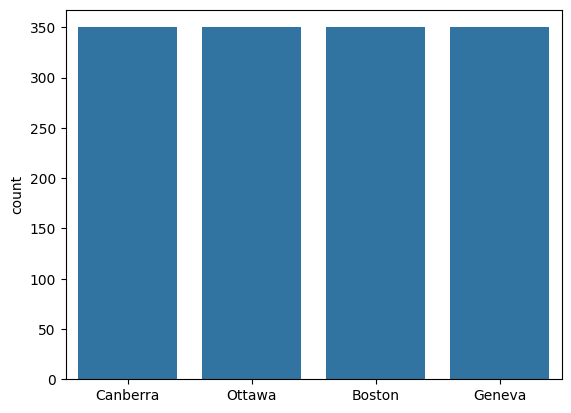

In [197]:
# visualize the bar chart for y values
sns.countplot(x=train_y)
plt.show()

Looking below at the first few training values, it's clear that there's a lot of confusing data, we would probably need to remove the URL links and the markdown features, however based on intial testing it seems like markdown is handled by the standard vectorizer

# Explore Data

Let's first observe the unprocessed data and its most frequently used words

In [198]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def word_cloud(data, title, stop):
  # Assuming `your_numpy_array` is a NumPy array containing text data
  mh_text = ' '.join(data.flatten())  # Flatten & convert to single string

  # Initialize WordCloud instance
  wordcloud = WordCloud(stopwords=stop, background_color="white", max_font_size=80, max_words=20)

  # Generate WordCloud
  wordcloud.generate(mh_text)

  # Plot WordCloud
  plt.figure(figsize=(10, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.gca().set_title(title, fontsize=25)
  plt.axis("off")
  plt.show()

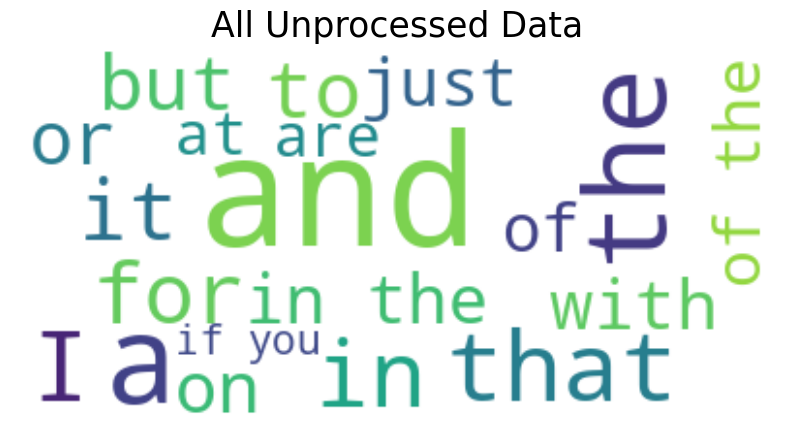

In [199]:
# World cloud of all unprocessed data
word_cloud(train_x, "All Unprocessed Data", [])

It's clear that it's all stop words so we need to remove them

## Stop Words
Words like ‘is’, ‘are’, ‘am’, ‘he’, ‘she’ are stop words, they add no context to our dataset, let's define reddit specific stop words and standard stop words

In [200]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction import text # Import the 'text' module from sklearn

# stop word
stop_words = list(text.ENGLISH_STOP_WORDS)

reddit_stop_words = ['www', 'reddit', 'http', 'https' 'upvote', 'downvote', 'karma', 'post', 'comment', 'edit', 'subreddit']

stop_words.extend(reddit_stop_words)

# Common words in all four subreddits
common_terms = ['people', 'time', 'like', 'just', 'dont', 'good', 'want', 'year', 'im', 'really', 'ive', 'lot']

common_terms.extend(stop_words)

In [201]:
print(common_terms)

['people', 'time', 'like', 'just', 'dont', 'good', 'want', 'year', 'im', 'really', 'ive', 'lot', 'couldnt', 'almost', 'yet', 'about', 'ltd', 'hereafter', 'might', 'go', 'further', 'rather', 'which', 'con', 'seem', 'done', 'system', 'whence', 'beyond', 'must', 'un', 'meanwhile', 'he', 'serious', 'amongst', 'but', 'together', 'if', 'made', 'hasnt', 'are', 'cannot', 'some', 'therefore', 'only', 'it', 'please', 'his', 'twenty', 'therein', 'ie', 'sincere', 'still', 'anywhere', 'etc', 'over', 'without', 'cant', 'fire', 'nor', 'that', 'thence', 'hers', 'across', 'whither', 'when', 'also', 'such', 'detail', 'toward', 'another', 'twelve', 'side', 'became', 'seemed', 'fifteen', 'always', 'few', 'themselves', 'these', 'found', 'indeed', 'the', 'latterly', 'last', 'into', 'more', 'be', 'at', 'thereafter', 'top', 'against', 'fifty', 'wherever', 'becoming', 'than', 'thick', 'and', 'we', 'seems', 'they', 'very', 'yourself', 'mill', 'sometime', 'eight', 'whereas', 'hundred', 'become', 'you', 'througho

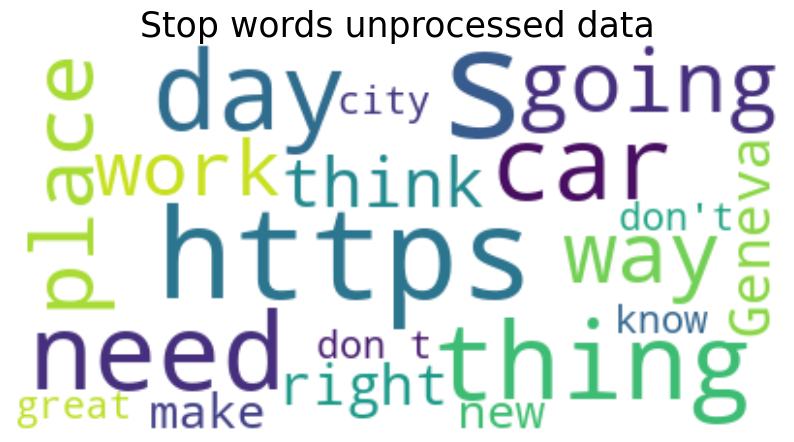

In [202]:
word_cloud(train_x, "Stop words unprocessed data", common_terms)

We still see some problems with the data like links.

## Preprocessed Reddit Data

We proceed by preprocessing the text data, as text normalization is required to obtain usable data observations
and increase prediction accuracy.

In [203]:
import re
import string
import unicodedata

def preprocess_text(X):
    # X_copy = X.copy() # Removed the line causing error
    X_copy = [x for x in X]  # Created a list from input if its not a list
    if type(X) is str:
        X_copy = [X]
    for i, text in enumerate(X_copy):  # Using enumerate to get index
        # Remove URLs
        text = re.sub(r'http\S+', '', text)

        # Remove anything in paranthesis
        text = re.sub(r'\[.*?\]|\(.*?\)', '', text)

        # Remove special characters and numbers
        text = re.sub(r'\d+', '', text)

        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation

        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))

        # Remove differences in city words
        mapping = {
            r'\bbost[A-Za-z]*': 'Boston',  # Matches "bost", "bosto", "boston", etc.
            r'\bgenev[A-Za-z]*': 'Geneva',  # Matches "genev", "geneve", "genevish", etc.
            r'\bcanberr[A-Za-z]*': 'Canberra',  # Matches "canberr", "canberra", etc.
            r'\botta[A-Za-z]*': 'Ottawa',  # Matches "otta", "ottawa", etc.
        }


        # Iterate over each pattern and replace occurrences with the correct city name
        for pattern, replacement in mapping.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        X_copy[i] = text  # Updating original list with modified text
    # To track grid search

    #If input is string return string
    if type(X) is str:
      return X_copy[0]
    #Otherwise return list
    else:
      return X_copy

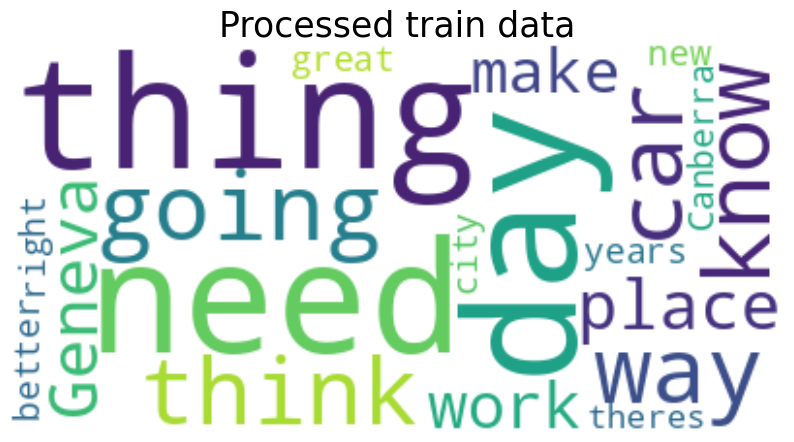

In [204]:
# Preprocess train data
preprocessed_train_x = np.array(preprocess_text(train_x))
word_cloud(preprocessed_train_x, "Processed train data", common_terms)

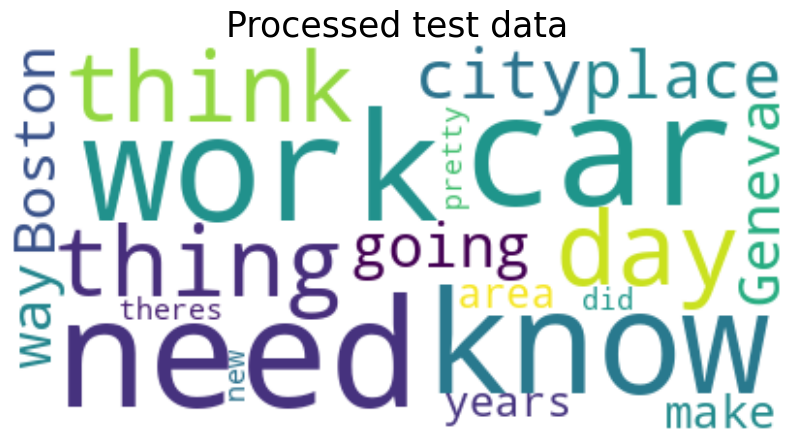

In [205]:
# Preprocess data for test
preprocessed_test_x = np.array(preprocess_text(test_x))
world_cloud = word_cloud(preprocessed_test_x, "Processed test data", common_terms)

Let's individually analyze the data for each city

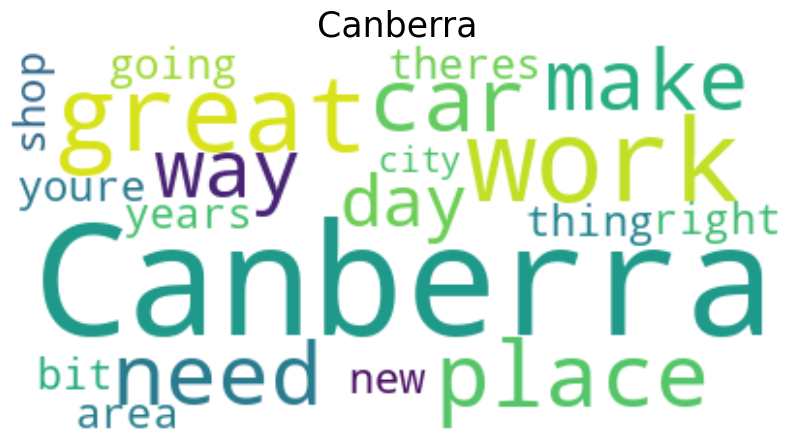

In [206]:
# Preprocessed data for Canberra
canberra_data = preprocessed_train_x[train_y == 'Canberra']
word_cloud(canberra_data, "Canberra", common_terms)

In [207]:
# Generate the world cloud result
wordcloud = WordCloud(stopwords=[]).generate(" ".join(canberra_data))

# Extract words from the word cloud
canberra_words = list(wordcloud.words_.keys())

# Print the extracted words
print(canberra_words)

['the', 'a', 'and', 'i', 'to', 'it', 'that', 'in', 'for', 'of', 'but', 'with', 'on', 'you', 'or', 'so', 'of the', 'there', 'this', 'not', 'are', 'in the', 'wa', 'at', 'my', 'just', 'Canberra', 'they', 'from', 'up', 'about', 'an', 'also', 'one', 'we', 'like', 'time', 'if', 'has', 'them', 'good', 'more', 'have', 'some', 'their', 'people', 'get', 'me', 'your', 'on the', 'what', 'year', 'out', 'all', 'by', 'you can', 'if you', 'great', 'place', 'any', 'do', 'car', 'at the', 'other', 'back', 'work', 'she', 'were', 'too', 'really', 'be', 'down', 'when', 'day', 'no', 'then', 'very', 'over', 'area', 'who', 'had', 'well', 'can', 'which', 'will', 'only', 'because', 'even', 'thing', 'to be', 'around', 'right', 'have a', 'in Canberra', 'a few', 'ive', 'im', 'where', 'into', 'how', 'shop', 'it was', 'he', 'after', 'got', 'would', 'i have', 'go', 'come', 'road', 'new', 'said', 'through', 'service', 'now', 'make', 'for a', 'to get', 'there i', 'a bit', 'way', 'before', 'need', 'being', 'a lot', 'neve

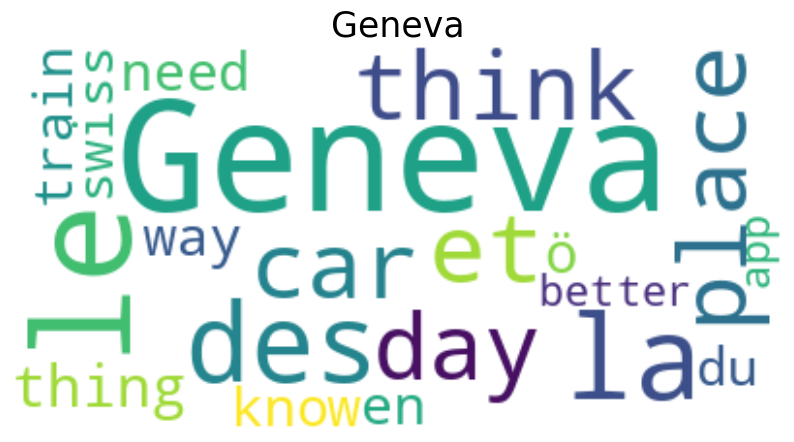

In [208]:
# Preprocessed data for Geneva
geneva_data = preprocessed_train_x[train_y == 'Geneva']
word_cloud(geneva_data, "Geneva", common_terms)

In [209]:
# Generate the world cloud result
wordcloud = WordCloud(stopwords=[]).generate(" ".join(geneva_data))

# Extract words from the word cloud
geneva_words = list(wordcloud.words_.keys())

# Print the extracted words
print(geneva_words)

['and', 'a', 'the', 'i', 'to', 'it', 'in', 'that', 'for', 'but', 'de', 'of', 'you', 'not', 'with', 'or', 'on', 'they', 'this', 'so', 'are', 'your', 'you can', 'le', 'at', 'an', 'if', 'if you', 'them', 'from', 'there', 'just', 'of the', 'some', 'in the', 'one', 'also', 'my', 'like', 'me', 'in Geneva', 'people', 'Geneva', 'do', 'time', 'more', 'very', 'la', 'get', 'be', 'here', 'for the', 'et', 'we', 'even', 'good', 'their', 'on the', 'un', 'no', 'by', 'place', 'all', 'was', 'about', 'day', 'really', 'thing', 'other', 'who', 'will', 'ö', 'only', 'for a', 'where', 'up', 'car', 'to be', 'you are', 'en', 'too', 'because', 'what', 'swiss', 'has', 'there i', 'it i', 'had', 'im', 'i dont', 'go to', 'i was', 'app', 'there are', 'something', 'were', 'out', 'any', 'around', 'a few', 'have to', 'then', 'use', 'quite', 'when', 'price', 'french', 'back', 'want to', 'after', 'year', 'always', 'local', 'better', 'many', 'you have', 'will be', 'a lot', 'to go', 'have', 'much', 'how', 'with the', 'that 

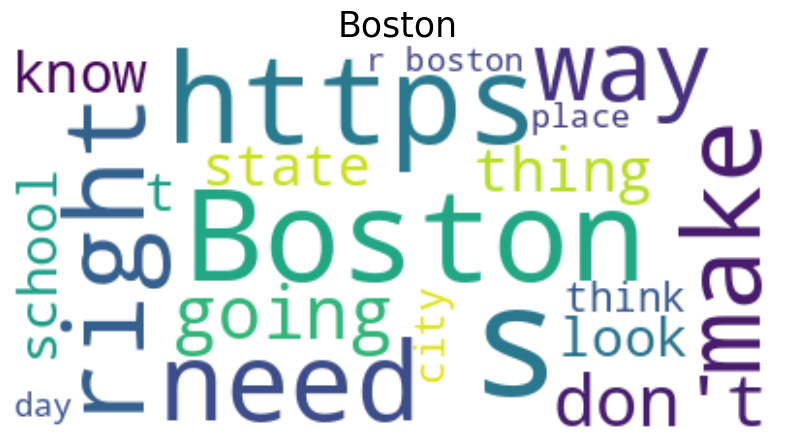

In [210]:
# Preprocessed data for Boston
boston_data = train_x[train_y == 'Boston']
word_cloud(boston_data, "Boston", common_terms)

In [211]:
# Generate the word cloud (assuming 'word_cloud' is your function that creates it)
wordcloud = WordCloud(stopwords=[]).generate(" ".join(boston_data))

# Extract words from the word cloud
boston_words = list(wordcloud.words_.keys())

# Print the extracted words
print(boston_words)

['and', 'the', 'a', 'i', 'to', 'that', 'it', 'of', 'in', 'for', 'but', 'you', 'on', 'not', 'are', 'or', 'in the', 'they', 'people', 'so', 'with', 'like', 'your', 'this', 'all', 'just', 'at', 'about', 'their', 'of the', 'if you', 'them', 'from', 'there', 'https www', 'more', 'have', 'up', 'get', 'what', 'out', 'by', 'here', 's', 'my', 'we', 'when', 'has', 'also', 'to be', 'good', 'way', 'on the', 'some', 'right', 'do', 'he', 'thing', 'it s', 'how', 'our', 'one', 'time', 'was', 'other', 'be', 'around', 'because', 'you can', 'will', 'an', 'had', 'make', 'take', 'in a', 'too', 'you have', 'state', 'very', 'u', 'now', 'r boston', 'know', 'place', 'being', 'then', 'no', 'year', 'off', 'for the', 'into', 'even', 'would', 'who', 'most', 'at the', 'have a', 'going to', 'look', 'great', 'for a', 'this i', 'to do', 'if', 'over', 'where', 'any', 'still', 'only', 'hi', 'I m', "don't", 'than', "I'm", 'day', 'me', 'school', 'while', 'work', 'new', 'need to', 'with the', 'were', 'immigrant', 'want to'

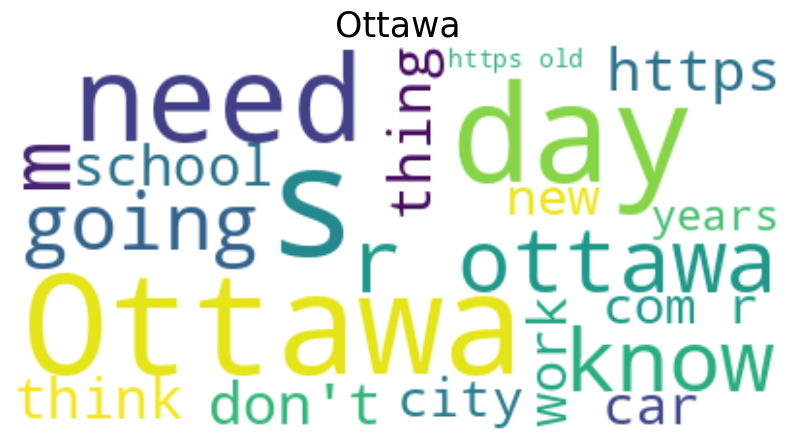

In [212]:
# Preprocessed data for Ottawa
ottawa_data = train_x[train_y == 'Ottawa']
wordcloud = word_cloud(ottawa_data, "Ottawa", common_terms)

In [213]:
# Generate the word cloud (assuming 'word_cloud' is your function that creates it)
wordcloud = WordCloud(stopwords=[]).generate(" ".join(ottawa_data))

# Extract words from the word cloud
ottawa_words = list(wordcloud.words_.keys())

# Print the extracted words
print(ottawa_words)

['and', 'a', 'the', 'I', 'to', 'that', 'it', 'for', 'in', 'of', 'with', 'on', 'but', 'you', 'are', 'they', 'there', 'my', 'not', 'just', 'so', 'in the', 'at', 'or', 'this', 'we', 'an', 'their', 'your', 'if you', 'people', 'time', 'of the', 'get', 'some', 'like', 'also', 'one', 'all', 'from', 'up', 'them', 'what', 'to the', 'was', 'will', 'me', 'out', 'day', 'had', 'on the', 'other', 'more', 'year', 'who', 'I was', 'about', 'r ottawa', 's', 'really', 'you can', 'if', 'he', 'thing', 'it s', 'when', 'no', 'our', 'to be', 'then', 'back', 'at the', 'in a', 'I have', 'I m', 'https www', 'even', 'now', 'work', 'car', 'it was', 'have a', 'off', 'by', 'because', 'new', 'school', 'two', 'here', 'would', 'to get', 'you have', 'reddit com', 'com r', 'very', 'good', 'never', 'after', 'how', 'still', 'https old', 'old reddit', 'ottawa comments', 'comments 1hm3rjz', '1hm3rjz please_note_veuillez_noter', 'home', 'use', 'take', 'ˇ', 'around', 'don t', 'has been', 'a few', 'could', 'help', 'great', 'do'

It makes sense that cities like Canberra and Ottowa have a high percentage of the usage of words like "Car" as they're not walkable cities. This was evident in our cross validation and confusion matrix analysis where we saw high confusion between the two cities.

The word clouds also show that preprocessing the data is useful, since the name of the city is now one of the most frequent words

# Feature Engineering & Reduction


We explored the use of lemmatization but since we are creating our own stop word list, we instead choose to opt out of using it as bigrams benefit from context

## Vectorizer

TF-IDF (Term Frequency-Inverse Document Frequency) is the recommended vectorizer for this task as it:

Normalizes for document length, downweights common terms across all city subreddits and emphasizes unique, distinctive terms for each city

We want to experiment with different vectorizers to see the effects of n-grams, binary, lemmatization and other features

In [230]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import word_tokenize

tfidf_vectorizer = TfidfVectorizer(
    min_df=2,  # Ignore terms that appear in less than 2 documents
    ngram_range=(1, 2),  # Use unigrams
    sublinear_tf=True,  # Apply sublinear tf scaling (log scaling)
    stop_words=stop_words,
)
count_vectorizer = CountVectorizer(
    min_df=2,  # Ignore terms that appear in less than 2 documents
    ngram_range=(1, 1),  # Use unigrams
    stop_words=stop_words,
)

## Feature & Dimension Reduction
Early tests indicated that there are still  too many features even after definiing the TF-IDF range, we will need to employ some sort dimensionality and feature reduction. Chi-Square is a feature reduction technique that chooses the best features for city classification

In [231]:
from sklearn.feature_selection import SelectKBest, chi2
chi_selector = SelectKBest(chi2, k=1000)  # Select top 10,000 features

To filter out really noisy reddit posts, we can also reduce employ a feature reduction strategy called SVD. Additionally other dimension reduction techniques include NMF.
https://stackoverflow.com/questions/19714108/supervised-dimensionality-reduction-for-text-data-in-scikit-learn

In [232]:
from sklearn.decomposition import TruncatedSVD, NMF
svd = TruncatedSVD(n_components=2000)

# Model Selection

## Bernoulli Naive Bayes


We will implement Bernoulli NB, using Laplace Smoothing.

Our fit function will find the prior and likelihood probabilities

Our predict function find the log-likelihood probability for each class given a sample, we implement it using the following function
$\log P(c \mid x) \propto \log \theta_c + \sum_{i=1}^n \left( x_i \log \theta_{i|c} + (1 - x_i) \log (1 - \theta_{i|c}) \right)$

In [233]:
# To use sklearn built-in functions make it a subclass
from sklearn.base import BaseEstimator, ClassifierMixin

class BernoulliNB_1(BaseEstimator, ClassifierMixin):
  def __init__(self, smoothing=0.0):
      """
      Bernoulli Naive Bayes Classifier

      Params:
      - smoothing (float): Laplace smoothing parameter
      - theta_jc (Numpy array): List of conditional probabilities
      - theta_class (Numpy array): List of prior probabilities
      """
      self.smoothing = smoothing # parameter for laplace smoothing set 1.0
      self.theta_jc = None
      self.theta_class = None
      self.classes = None

  def fit(self, X, y_train):
      """
      Bernoulli Naive Bayes fit function that takes training data and returns prior and conditional probabilities

      Params:
      - X_train (Numpy array): Training feature data
      - y_train (Numpy array): Trainig label data

      Returns:
      - theta_class (Numpy array): List of prior probabilities
      - theta_jc (Numpy array): List of conditional probabilities
      """
      # Binarize the input
      X_train = (X > 0).astype(int)  # Convert all non-zero values to 1

      self.classes = np.unique(y_train) #['Boston' 'Canberra' 'Geneva' 'Ottawa']
      num_features = X_train.shape[1]
      num_classes = len(self.classes)

      #Probability that a feature is present given a class for a given input
      self.theta_jc = np.zeros((num_classes, num_features))

      #Prior probability of classes, initialize
      self.theta_class = np.zeros(num_classes)

      for i in range(num_classes):
        #Computing P(c)
        self.theta_class[i] = np.sum(y_train==self.classes[i]) / (len(y_train) + 0.0)
        #Computing theta_jc=P(x_j|c)
        class_mask = y_train == self.classes[i]
        #Optional Laplace Smoothing
        self.theta_jc[i,:] = np.sum(X_train[class_mask], axis=0) + self.smoothing
        self.theta_jc[i,:] /= np.sum(class_mask) + (2.0 * self.smoothing)

      return self.theta_class, self.theta_jc

  def predict(self, X):
      """
      Bernoulli Naive Bayes predictor that takes model inputs and gives probabilities of this test data belonging to each class.

      Params:
      - X_test (Numpy array): Test feature data

      Returns:
      - log_probs (Numpy array): List of log probabilities
      """
      num_classes = len(self.classes)

      X_test = (X > 0).astype(int)  # Convert all non-zero values to 1

      #(# data, # features)
      num_samples, num_features = X_test.shape

      #P(c|x (data)), each phrase has 4 probabilities
      log_probs = np.zeros((num_samples, num_classes))

      #Loop over each sample
      for i in range(num_samples):
        #Loop over each class
        for c in range(num_classes):
            #Initialize P(c|x)
            log_probs[i,c] = np.log(self.theta_class[c])
            #Loop over each feature
            for j in range(num_features):
                #Sum over every feature and it's log likelihood
                log_probs[i,c] += X_test[i,j] * np.log(self.theta_jc[c,j])
                log_probs[i,c] += (1.0 - X_test[i,j]) * np.log(1.0 - self.theta_jc[c,j])

      #Finally make the prediction by choosing the class with highest prob
      y_pred = np.argmax(log_probs, axis=1)


      return y_pred

  def score(self, X_test, y_test):
    #Score the accuracy
    y_pred = self.predict(X_test)
    return np.mean(y_pred == y_test)

  #From documentation to guide behaviour
  def get_params(self, deep=True):
    return {"smoothing": self.smoothing}

## SK Learn Models

We will use a plethora of built-in models to see which model (Logistic Regression, Linear Support Vector Machine, Multinomial Naïve Bayes, and a built-in
Bernoulli Naïve Bayes) provides us with the highest accuracy for our dataset.

In [234]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

# Initialize all the models
linear_svm = svm.LinearSVC(C=0.55, fit_intercept=False)
logistic_regression = LogisticRegression(C=1)
bernoulli_nb = BernoulliNB(alpha=0.1)
multi_nb = MultinomialNB()


# Testing Pipeline for Classifier and Vectorizer Hyperparameter Tuning

To test all the different preprocessing, feature and dimension reduction techniques and models. We need to develop a pipeline that automates that process. We will do so in this section
https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py

In [235]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer # for pipeline use

# Transform our preprocessing function to step for the pipeline
preprocessing = FunctionTransformer(preprocess_text)

noprocess = FunctionTransformer(lambda X: X)

pipeline = Pipeline([
    ('preprocess', preprocessing),
    ('vectorizer', tfidf_vectorizer),
    ('classifier', linear_svm)
])

Now let's design our test cases, we will first define a base parameter grid for all classifiers and then use Python's dictionary merging feature to also optimize the hyperparameters for each model.

NOTE: when using 'passthrough' error is caused because it doesn't have a field k or no, so we will run this twice and use the variable reduction as a controller

In [236]:
# Define parameter grid to test:
param_grid = {
      'preprocess': [preprocessing, noprocess],  # Test without preprocessing
      'vectorizer': [tfidf_vectorizer, count_vectorizer],  # Test both vectorizers
      'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Test N <3 N-grams
      'vectorizer__stop_words': [common_terms, stop_words],  # Test with and without stop words
}


In [237]:
# Linear Grid
linear_grid = {
    **param_grid, # Merge the base grid
    'classifier': [linear_svm],
    'classifier__penalty':["l2"],
    'classifier__C': [0.2, 0.4, 0.6, 0.8],
    'classifier__loss': ["hinge", "squared_hinge"],
    'classifier__tol':[1e-4],
    'classifier__max_iter': [1000],
    'classifier__class_weight': ["balanced"]

}

logistic_grid = {
    **param_grid,
    'classifier': [logistic_regression],
    'classifier__C': [0.01, 0.1, 1],                 # Regularization strength
    'classifier__penalty': ['l2', 'elasticnet'],        # Regularization types
    'classifier__solver': ['saga'],
    'classifier__max_iter': [1000]
}

bernoulli_grid = {
    **param_grid,
    'classifier': [bernoulli_nb],
    'classifier__alpha': [0.01, 0.1, 0.5],
    'classifier__fit_prior': [True, False],
    'classifier__class_prior': [[0.23, 0.23, 0.23, 0.31]] # Misclassifification of ottawa
}

multi_grid = {
    **param_grid,
    'classifier': [multi_nb],
    'classifier__alpha': [0.01, 0.1, 0.5],
    'classifier__fit_prior': [True, False],
    'classifier__class_prior': [[0.23, 0.23, 0.23, 0.31]] # Misclassifification of ottawa

}

xgb_grid = {
    'vectorizer__ngram_range': [(1,1), (1, 2)],  # Test N <3 N-grams
    'vectorizer__stop_words': [common_terms],  # Test with and without stop words
    'classifier__n_estimators': [100, 200],       # Fewer trees might underfit; 100-200 are balanced choices
    'classifier__max_depth': [3],                 # Lower depth reduces computation & prevents overfitting with small data
    'classifier__learning_rate': [0.03],     # Slightly higher learning rates to converge faster than 0.01
    'classifier__subsample': [0.7],               # Slight subsampling reduces overfitting, saves compute
    'classifier__colsample_bytree': [0.5],        # Selective features each tree for reduced computation and better generalization
}



# Model Testing

First let's start by splitting our data then we will use grid search, an sklearn function built with k cross validation features to help us optimize our
model hyperparameters and our text preprocessing

In [238]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings


X_train = train_x
y_train = train_y

# Split the data into training and testing sets
# Fold number set to low to first figure out which model is best
k=5

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [239]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# We define a function run analysis on the best model by printing the CM
def best_model(pipeline, X, Y, k):
    y_pred = cross_val_predict(svm_pipeline, X, Y, cv=k)

    # Build confusion matrix
    cm = confusion_matrix(Y, y_pred)
    print("Confusion Matrix (Out-of-Fold Predictions):\n", cm)

    labels = ['Boston', 'Canberra', 'Geneva', 'Ottawa']

    plt.imshow(cm, cmap=plt.cm.Blues)  # Basic colormap
    plt.title("Confusion Matrix (Out-of-Fold Predictions)")
    plt.colorbar()

    # Set up tick marks (one for each class)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)

    # Annotate each cell with the numerical counts
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j],
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='black')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    plt.show()

## Linear SVM

First, let's find the best parameters for the linear SVM model and calculate its accuracy score

In [240]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    grid_search = GridSearchCV(pipeline, linear_grid, cv=k, n_jobs=1, scoring='accuracy')
    grid_search.fit(X_train, y_train)


In [241]:
# After fitting grid_search_linear
results_df = pd.DataFrame(grid_search.cv_results_)
# Display the parameter settings and the corresponding mean test score
print(results_df[['params', 'mean_test_score', 'std_test_score']])

# Diplay the best settings
print("Best Settings:", grid_search.best_params_)
# Display the result
print("Best Score:", grid_search.best_score_)

                                                params  mean_test_score  \
0    {'classifier': LinearSVC(C=0.55, fit_intercept...         0.667143   
1    {'classifier': LinearSVC(C=0.55, fit_intercept...         0.672857   
2    {'classifier': LinearSVC(C=0.55, fit_intercept...         0.669286   
3    {'classifier': LinearSVC(C=0.55, fit_intercept...         0.668571   
4    {'classifier': LinearSVC(C=0.55, fit_intercept...         0.607857   
..                                                 ...              ...   
123  {'classifier': LinearSVC(C=0.55, fit_intercept...         0.702143   
124  {'classifier': LinearSVC(C=0.55, fit_intercept...         0.637857   
125  {'classifier': LinearSVC(C=0.55, fit_intercept...         0.647857   
126  {'classifier': LinearSVC(C=0.55, fit_intercept...         0.640714   
127  {'classifier': LinearSVC(C=0.55, fit_intercept...         0.645714   

     std_test_score  
0          0.029915  
1          0.027719  
2          0.024599  
3          

Now, we apply Chi-Squared dimensionality reduction on the linear SVM model

In [244]:
# Initialize the SVM classifier with the best parameters

# Import SVM classifier
from sklearn import svm

svm_classifier = svm.LinearSVC(
    C=0.4,
    loss='hinge',
    max_iter=5000,
    penalty='l2',
    tol=0.0001,
    fit_intercept=True,
    class_weight='balanced'
)

# The best vectorizer
svm_vectorizer = TfidfVectorizer(
    min_df=2,  # Ignore terms that appear in less than 2 documents
    ngram_range=(1, 2),  # Use unigrams
    sublinear_tf=True,  # Apply sublinear tf scaling (log scaling)
    stop_words=common_terms
)

# Pipeline definition with pass-through capability
svm_pipeline = Pipeline([
    ('vectorizer', svm_vectorizer),
    ('chi2', chi_selector),
    ('classifier', svm_classifier)
])

# Grid to optimize 'k' and 'n_components', including 'passthrough'
svm_grid = {
    'chi2__k': [1000, 2000, 2500, 'all'],          # 'all' effectively means no chi2 reduction
}

# Perform GridSearch
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    grid_search = GridSearchCV(
        svm_pipeline,
        svm_grid,
        cv=k,
        n_jobs=1,
        scoring='accuracy'
    )
    grid_search.fit(X_train, y_train)

# Display results
print("Best Settings:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Settings: {'chi2__k': 2000}
Best Score: 0.7321428571428571


Confusion Matrix (Out-of-Fold Predictions):
 [[249  29  27  45]
 [ 38 247  33  32]
 [ 24  20 286  20]
 [ 61  52  30 207]]


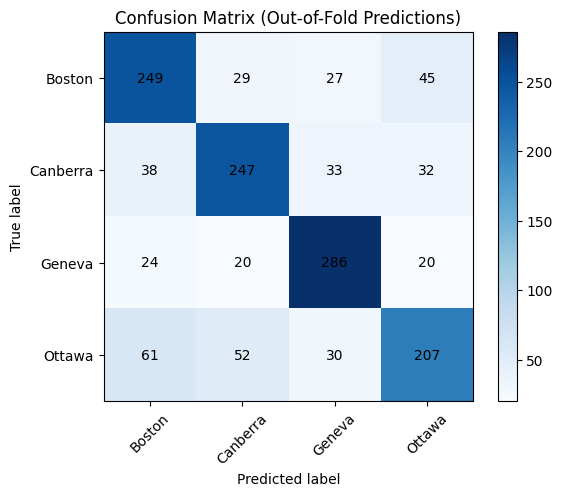

In [227]:
# Generate confusion matrix
best_model(svm_pipeline, X_train, y_train, k)

As the results show, implementing chi-squared increases accuracy

## Logistic Regression

Now, we run Logistic Regression on our data and determine the best parameters

In [245]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    grid_search = GridSearchCV(pipeline, logistic_grid, cv=k, n_jobs=1, scoring='accuracy')
    grid_search.fit(X_train, y_train)

# Display settings and result
print("Best Settings:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Settings: {'classifier': LogisticRegression(C=1), 'classifier__C': 1, 'classifier__max_iter': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'saga', 'preprocess': FunctionTransformer(func=<function <lambda> at 0x78e690eafc40>), 'vectorizer': TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                stop_words=['couldnt', 'almost', 'yet', 'about', 'ltd',
                            'hereafter', 'might', 'go', 'further', 'rather',
                            'which', 'con', 'seem', 'done', 'system', 'whence',
                            'beyond', 'must', 'un', 'meanwhile', 'he',
                            'serious', 'amongst', 'but', 'together', 'if',
                            'made', 'hasnt', 'are', 'cannot', ...],
                sublinear_tf=True), 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': ['people', 'time', 'like', 'just', 'dont', 'good', 'want', 'year', 'im', 'really', 'ive', 'lot', 'couldnt', 'almost', 'yet', 'about', 'ltd', 'hereafter', 'mi

The performance is tested again with chi-squared dimensionality reduction

In [246]:
# Use best and try feature reduction
logistic_classifier = LogisticRegression(
    C=1,
    max_iter=1000,
    penalty='l2',
    solver='saga'
)

# The best vectorizer is the same as the Linear SVM
# Pipeline to test feature reduction
logistic_pipeline = Pipeline([
    ('vectorizer', svm_vectorizer),
    ('chi2', chi_selector),
    ('classifier', logistic_classifier)
])

# Grid to optimize k value
logistic_grid = {
    'chi2__k': [1000, 2000, 3000, 4000],
}

# Cross validate and report results
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    grid_search = GridSearchCV(logistic_pipeline, logistic_grid, cv=k, n_jobs=1, scoring='accuracy')

# Display best output
grid_search.fit(X_train, y_train)

# Display settings and result
print("Best Settings:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Best Settings: {'chi2__k': 2000}
Best Score: 0.7142857142857143


The two accuracies are very similar; chi-squared does not significantly improve the model

Confusion Matrix (Out-of-Fold Predictions):
 [[249  29  30  42]
 [ 35 246  39  30]
 [ 21  17 292  20]
 [ 58  48  38 206]]


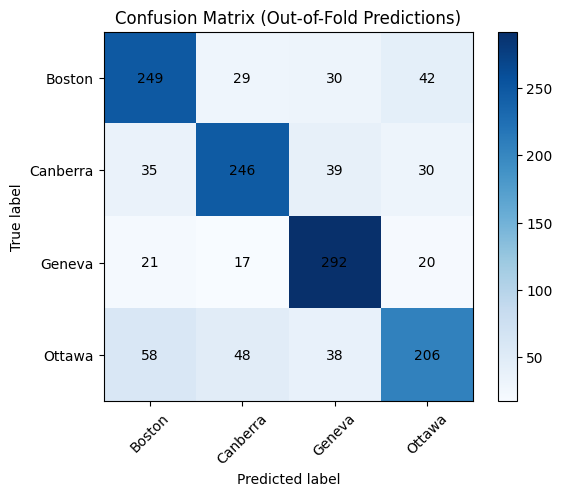

In [247]:
# Print the confusion matrix
best_model(logistic_pipeline, X_train, y_train, k)

## Bernoulli NB

Now, we determine the best parameters for the Bernoulli NB model

In [248]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    grid_search = GridSearchCV(pipeline, bernoulli_grid, cv=k, n_jobs=1, scoring='accuracy')
    grid_search.fit(X_train, y_train)

# Display settings and result
print("Best Settings:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Settings: {'classifier': BernoulliNB(alpha=0.1), 'classifier__alpha': 0.5, 'classifier__class_prior': [0.23, 0.23, 0.23, 0.31], 'classifier__fit_prior': True, 'preprocess': FunctionTransformer(func=<function <lambda> at 0x78e690eafc40>), 'vectorizer': TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                stop_words=['couldnt', 'almost', 'yet', 'about', 'ltd',
                            'hereafter', 'might', 'go', 'further', 'rather',
                            'which', 'con', 'seem', 'done', 'system', 'whence',
                            'beyond', 'must', 'un', 'meanwhile', 'he',
                            'serious', 'amongst', 'but', 'together', 'if',
                            'made', 'hasnt', 'are', 'cannot', ...],
                sublinear_tf=True), 'vectorizer__ngram_range': (1, 1), 'vectorizer__stop_words': ['people', 'time', 'like', 'just', 'dont', 'good', 'want', 'year', 'im', 'really', 'ive', 'lot', 'couldnt', 'almost', 'yet', 'about', 'ltd', 'hereafter', 'mi

We apply Chi-Squared dimensionality reduction on the Bernoulli NB model

In [249]:
bernoulli_nb = BernoulliNB(alpha=0.5)


# The best vectorizer
bernoulli_vectorizer = TfidfVectorizer(
    min_df=2,  # Ignore terms that appear in less than 2 documents
    ngram_range=(1, 1),  # Use unigrams
    sublinear_tf=True,  # Apply sublinear tf scaling (log scaling)
    stop_words=common_terms
)

# Pipeline to test feature reduction
bernoulli_pipeline = Pipeline([
    ('vectorizer', bernoulli_vectorizer),
    ('chi2', chi_selector),
    ('classifier', bernoulli_nb)
])

# Grid to optimize k value
bernoulli_grid = {
    'chi2__k': [1000, 2000, 3000, 4000],
}



# Cross validate and report results
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    grid_search = GridSearchCV(bernoulli_pipeline, bernoulli_grid, cv=k, n_jobs=1, scoring='accuracy')
    grid_search.fit(X_train, y_train)


In [250]:
# Display settings and result
print("Best Settings:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Settings: {'chi2__k': 1000}
Best Score: 0.6892857142857143


We see an improvement so we will use feature reduction for Bernoulli NB

Confusion Matrix (Out-of-Fold Predictions):
 [[249  29  30  42]
 [ 35 246  39  30]
 [ 21  17 292  20]
 [ 58  48  38 206]]


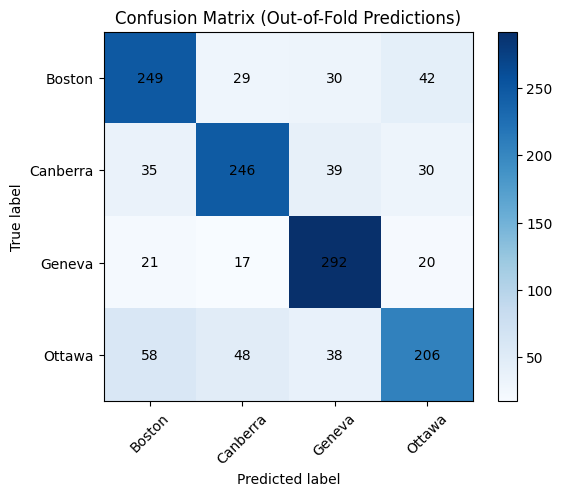

In [251]:
# print the confusion matrix
best_model(bernoulli_pipeline, X_train, y_train, k)

## Multinomial NB

We determine the best parameters for the Multinommial NB model and find its accuracy on the data

In [252]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    grid_search = GridSearchCV(pipeline, multi_grid, cv=k, n_jobs=1, scoring='accuracy')
    grid_search.fit(X_train, y_train)

# Display settings and result
print("Best Settings:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Settings: {'classifier': MultinomialNB(), 'classifier__alpha': 0.5, 'classifier__class_prior': [0.23, 0.23, 0.23, 0.31], 'classifier__fit_prior': True, 'preprocess': FunctionTransformer(func=<function <lambda> at 0x78e690eafc40>), 'vectorizer': TfidfVectorizer(min_df=2, ngram_range=(1, 2),
                stop_words=['couldnt', 'almost', 'yet', 'about', 'ltd',
                            'hereafter', 'might', 'go', 'further', 'rather',
                            'which', 'con', 'seem', 'done', 'system', 'whence',
                            'beyond', 'must', 'un', 'meanwhile', 'he',
                            'serious', 'amongst', 'but', 'together', 'if',
                            'made', 'hasnt', 'are', 'cannot', ...],
                sublinear_tf=True), 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': ['people', 'time', 'like', 'just', 'dont', 'good', 'want', 'year', 'im', 'really', 'ive', 'lot', 'couldnt', 'almost', 'yet', 'about', 'ltd', 'hereafter', 'might', '

We run the model again using chi-squared   dimensionality reduction

In [253]:
# Pipeline to test feature reduction
multi_pipeline = Pipeline([
    ('vectorizer', bernoulli_vectorizer),
    ('chi2', chi_selector),
    ('classifier', multi_nb)
])

# Cross validate and report results
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    grid_search = GridSearchCV(multi_pipeline, bernoulli_grid, cv=k, n_jobs=1, scoring='accuracy')
    grid_search.fit(X_train, y_train) #Fit before trying to access attributes

# Display settings and result
print("Best Settings:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Settings: {'chi2__k': 1000}
Best Score: 0.7007142857142858


Running the model with chi-squared does not improve the accuracy

Confusion Matrix (Out-of-Fold Predictions):
 [[249  29  30  42]
 [ 35 246  39  30]
 [ 21  17 292  20]
 [ 58  48  38 206]]


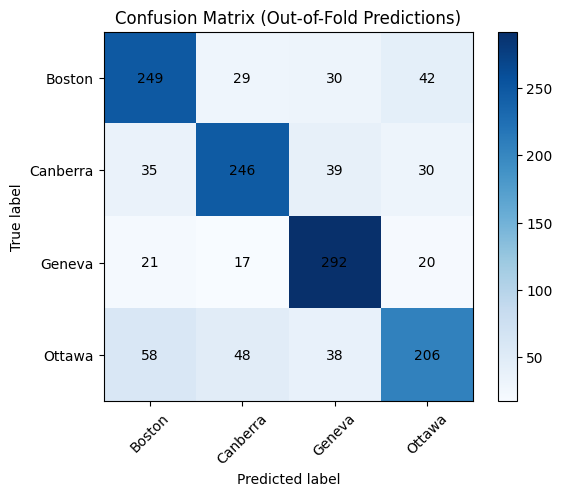

In [254]:
# Print the confusion matrix
best_model(multi_pipeline, X_train, y_train, k)

# Kaggle Output
Based on the best setting for all three of our models, we will run our test output on those trained models so that we can ensure that we get the highest score

We will now create the function that will output the csv file for kaggle

In [177]:
from scipy.special import expit  # Sigmoid function

# Predict for kaggle output
def kaggle_output(model, test_x, test_id, filename='cities.csv', svm=False):
    # Predict the probabilities for meta classifier
    if (svm):
      y_pred_test = model.predict(test_x)
      y_pred_prob = model.decision_function(test_x)
      y_pred_prob = expit(y_pred_prob) # Convert into pseudo probabilites

    else:
      y_pred_prob = model.predict_proba(test_x)
      # Convert probabilities into label
      y_pred_test = np.argmax(y_pred_prob, axis=1)

    # Convert back to city names using cities list
    if (not isinstance(y_pred_test[0], str)):
      y_pred_test = [cities[i] for i in y_pred_test]

    # Combine into DataFrame
    df = pd.DataFrame({
        'id': test_id,
        'subreddit': y_pred_test
    })

    # Write to CSV
    df.to_csv(filename, index=False)

    # Combine into DataFrame
    df = pd.DataFrame({
        'id': test_id,
        'subreddit': y_pred_test
    })

    # Write to CSV
    df.to_csv(filename, index=False)

    return y_pred_prob

## Linear SVM
We achieved an accuracy 0.7333

In [187]:
# Vectorize my train and test
svm_x_train = svm_vectorizer.fit_transform(train_x)
svm_x_test = svm_vectorizer.transform(test_x)
svm_chi = SelectKBest(chi2, k='all')
print(svm_x_train.shape)
print(svm_x_test.shape)

# Perform optimal chi squared reduction
svm_x_train = svm_chi.fit_transform(svm_x_train, train_y)
svm_x_test = svm_chi.transform(svm_x_test)

print(svm_x_train.shape)

# Fit SVM
svm_classifier.fit(svm_x_train, train_y)

# predict on train
y_pred_train_svm = svm_classifier.predict(svm_x_train)

# Find probabilties of train
y_pred_prob_train_svm = svm_classifier.decision_function(svm_x_train)
y_pred_prob_train_svm = expit(y_pred_prob_train_svm)

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['didn', 'shouldn', 'wouldn'] not in stop_words.
  warnings.warn(


(1400, 59910)
(600, 59910)
(1400, 59910)


In [188]:
# Get the output
svm_y = kaggle_output(svm_classifier, svm_x_test, test_id,
                      'cities_svm.csv', svm=True)

## Bernoulli NB
For this model, we will use our own implementation therefore we will need to extract the best laplace smoothing parameter first.
We achieved an accuracy 0.6444 which is very low, therefore we opt to not use Bernoulli NB in our stacking classifier

In [ ]:
# Vectorize train and test
bernoulli_x_train = bernoulli_vectorizer.fit_transform(train_x)
bernoulli_x_test = bernoulli_vectorizer.transform(test_x)

bernoulli_chi = SelectKBest(chi2, k=1000)

print(bernoulli_x_train.shape)
print(bernoulli_x_test.shape)

# Perform chi
bernoulli_x_train = bernoulli_chi.fit_transform(bernoulli_x_train, train_y)
bernoulli_x_test = bernoulli_chi.transform(bernoulli_x_test)

# Initialize using our own implementation
bernoulli_nb = BernoulliNB_1(smoothing=0.5)

# Fit the classifier
bernoulli_nb.fit(bernoulli_x_train, train_y)

# Predict on train
y_pred_train_bernoulli = bernoulli_nb.predict(bernoulli_x_train)

# Get the output
bernoulli_y = kaggle_output(bernoulli_nb, bernoulli_x_test, test_id, 'cities_bernoulli.csv')


## Logistic Regression

In [ ]:
# vectorize train and test using svm vectorizer
logistic_x_train = svm_vectorizer.fit_transform(train_x)
logistic_x_test = svm_vectorizer.transform(test_x)

logistic_chi = SelectKBest(chi2, k=2000)

print(logistic_x_train.shape)
print(logistic_x_test.shape)

# Perform chi
logistic_x_train = logistic_chi.fit_transform(logistic_x_train, train_y)
logistic_x_test = logistic_chi.transform(logistic_x_test)

# Fit the classifier
logistic_classifier.fit(logistic_x_train, train_y)

# Get the outpit
logistic_y = kaggle_output(logistic_classifier, logistic_x_test, test_id, 'cities_logistic.csv')

# Find probabilties
y_pred_prob_train_logistic = logistic_classifier.predict_proba(logistic_x_train)

(1400, 7367)
(600, 7367)


## Multinomial NB

In [ ]:
# vectorize and train using bernoulli NB vectorizer
multi_x_train = bernoulli_vectorizer.fit_transform(train_x)
multi_x_test = bernoulli_vectorizer.transform(test_x)

# multi_chi = SelectKBest(chi2, k=1000)

# print(multi_x_train.shape)
# print(multi_x_test.shape)

# # Perform chi
# multi_x_train = multi_chi.fit_transform(multi_x_train, train_y)
# multi_x_test = multi_chi.transform(multi_x_test)

# Fit the classifier
multi_nb.fit(multi_x_train, train_y)

# Predict the probabilities
y_pred_prob_train_multi = multi_nb.predict_proba(multi_x_train)

# Get the output
multi_y = kaggle_output(multi_nb, multi_x_test, test_id, 'cities_multi.csv')

## Using Gradient Boosting as a Stacking Classifier
Stacking helps us learn from the mistakes of other classifiers to get the best output, we use those individually trained models as a basis to train the second layer which should in theory improve the overall accuracy of the data

We achieved an accuracy of 0.7 with this method

In [ ]:
# Print train prob outputs
print(y_pred_prob_train_svm)
print(y_pred_prob_train_logistic)
print(y_pred_prob_train_multi)

# Print test outputs
print(svm_y[0])
print(logistic_y[0])
print(multi_y[0])

In [ ]:
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb


# Stack predictions as features for the meta-classifier.
xgb_train_features = np.column_stack((
    y_pred_prob_train_svm,
    y_pred_prob_train_logistic,
    y_pred_prob_train_multi
))

xgb_test_features = np.column_stack((
    svm_y,
    logistic_y,
    multi_y
))

print(xgb_train_features.shape)
print(xgb_test_features.shape)


xgb_params = {
    'objective': 'multi:softmax',
    'num_class': 4,
    # 'tree_method': 'gpu_hist'  # Enables GPU acceleration
}

meta_clf = xgb.XGBClassifier(objective='multi:softmax', num_class=4) #tree_method='gpu_hist'

# Fit the XGBClassifier to the stacked features
meta_clf.fit(xgb_train_features, encoded_train_y)

# Get the output
stacked_y = kaggle_output(meta_clf, xgb_test_features, test_id, 'stacked_cities.csv') #Changed to xgb_test_features

NameError: name 'y_pred_prob_train_logistic' is not defined